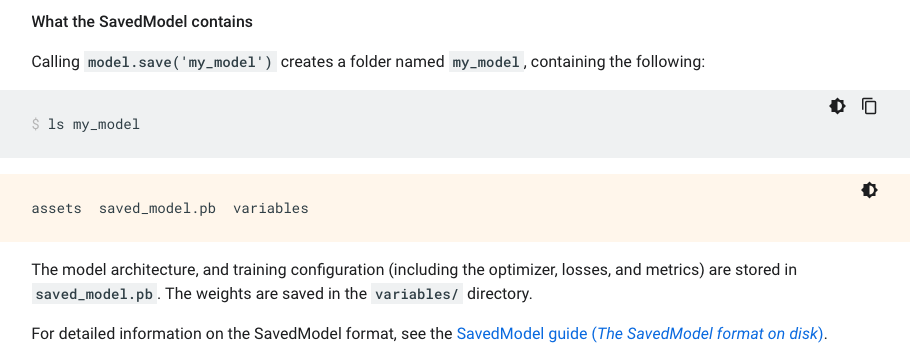

In [3]:
from IPython.display import Image
Image(filename='SavedModel.png') 

In [6]:
#pb-pbtxt-converter (https://gist.github.com/nimaid/17559858c7be0c6668142e258b894126)

import argparse, os, pathlib, sys
def file_path(string):
    if os.path.isfile(string):
        return string
    else:
        raise FileNotFoundError(string)
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", type=file_path, required=True,
    help="path to input file, either .pb or .pbtxt")
args = vars(ap.parse_args())

# Get input filename parts
in_dir = os.path.dirname(args["input"])
in_name, in_ext = os.path.splitext(os.path.basename(args["input"]))
in_ext = in_ext.lower()

# Verify it is a valid extention
if in_ext == ".pb":
    to_pb = False
    out_filename = os.path.join(in_dir, in_name + ".pbtxt")
elif in_ext == ".pbtxt":
    to_pb = True
    out_filename = os.path.join(in_dir, in_name + ".pb")
else:
    raise argparse.ArgumentTypeError("File must be either a .pb or .pbtxt file")

# Verify that out file doesn't already exist
if os.path.exists(out_filename):
    if os.path.isfile(out_filename):
        raise FileExistsError("Output file already exists: '{}'".format(out_filename))

# Import after argparse so as to not waste time with bad arguments
import tensorflow as tf
from google.protobuf import text_format
from tensorflow.python.platform import gfile

def pbtxt_to_graphdef(filename):
    print("\n[CONVERT] Converting from .pbtxt to .pb: '{}'\n".format(filename))
    with open(filename, 'r') as f:
        graph_def = tf.GraphDef()
        file_content = f.read()
        text_format.Merge(file_content, graph_def)
        tf.import_graph_def(graph_def, name='')
        in_dir = os.path.dirname(filename)
        out_filename = os.path.splitext(os.path.basename(filename))[0] + ".pb"
        tf.train.write_graph(graph_def, in_dir, out_filename, as_text=False)
    print("\n[CONVERT] Wrote file to: '{}'\n".format(os.path.join(in_dir, out_filename)))

def graphdef_to_pbtxt(filename):
    print("\n[CONVERT] Converting from .pb to .pbtxt: '{}'\n".format(filename))
    with gfile.FastGFile(filename,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        in_dir = os.path.dirname(filename)
        out_filename = os.path.splitext(os.path.basename(filename))[0] + ".pbtxt"
        tf.train.write_graph(graph_def, in_dir, out_filename, as_text=True)
    print("\n[CONVERT] Wrote file to: '{}'\n".format(os.path.join(in_dir, out_filename)))

if to_pb:
    pbtxt_to_graphdef(args["input"])
else:
    graphdef_to_pbtxt(args["input"])

usage: ipykernel_launcher.py [-h] -i INPUT
ipykernel_launcher.py: error: the following arguments are required: -i/--input


SystemExit: 2

In [ ]:
#checkpoint to pb (https://www.programmersought.com/article/38376724340/)

import tensorflow as tf
from tensorflow.python.framework import graph_util
 
def ckpt2pb():
    with tf.Graph().as_default() as graph_old:
        isess = tf.InteractiveSession()
 
        ckpt_filename = 'model.ckpt-101'
        isess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(ckpt_filename+'.meta', clear_devices=True)
        saver.restore(isess, ckpt_filename)
        op = tf.get_default_graph().get_operations()
        print(op[5650:-1])
 
        constant_graph = tf.compat.v1.graph_util.convert_variables_to_constants(isess, isess.graph_def, ['save/restore_all'])
        constant_graph = tf.compat.v1.graph_util.remove_training_nodes(constant_graph)
 
        with tf.io.gfile.GFile('model.pb', mode='wb') as f:
            f.write(constant_graph.SerializeToString())
        
ckpt2pb()

In [ ]:
#tensorflow model to pb (https://stackoverflow.com/questions/60005661/tensorflow-2-0-convert-keras-model-to-pb-file)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from keras import backend as K

tf.keras.backend.set_learning_phase(0)

pre_model = tf.keras.models.load_model("final_model.h5")

print(pre_model.inputs)
print(pre_model.outputs)

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.compat.v1.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.compat.v1.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.compat.v1.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(tf.compat.v1.keras.backend.get_session(), output_names=[out.op.name for out in pre_model.outputs])